In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("..\\datasets\\16-spam-detection-using-tensorflow\\SPAM text message 20170820 - Data.csv")
# data source : https://www.kaggle.com/datasets/team-ai/spam-text-message-classification/data

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


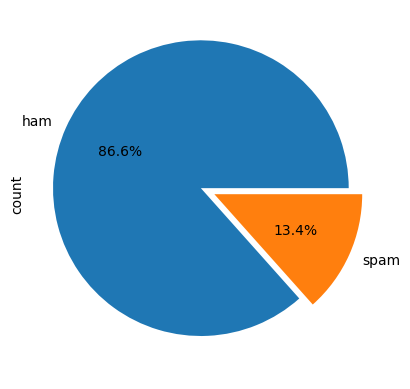

In [4]:
category_df=data['Category'].value_counts().plot(kind='pie',autopct='%1.1f%%',explode=(0.1,0))

In [5]:
import nltk
import re
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stemmer=nltk.SnowballStemmer('english')
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower() #lower case all text
    text = re.sub('\[.*?\]', '', text) # remove all characters between []
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('<.*?>+', '', text) # remove all characters between <>
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text) # remove line breaker
    text = re.sub('\w*\d\w*', '', text) # remove word with numbers
    text = [word for word in text.split(' ') if word not in stopword] # remove word if in stopword
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')] #stemming
    text=" ".join(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#data['Message']=data['Message'].apply(clean)

In [7]:
spam_word_array=[]
for m in data[data['Category']=='spam']['Message'].to_list():
    for word in m.split():
        spam_word_array.append(word)
df=pd.DataFrame(spam_word_array).value_counts().to_frame().head(20)
df.T.style.background_gradient(cmap='Reds',axis=1)

0,"('to',)","('a',)","('your',)","('or',)","('call',)","('the',)","('2',)","('for',)","('you',)","('is',)","('Call',)","('on',)","('have',)","('and',)","('from',)","('ur',)","('with',)","('&',)","('4',)","('of',)"
count,604,360,187,185,183,175,169,169,164,142,136,136,125,119,116,107,101,98,93,93


In [8]:
ham_word_array=[]
for m in data[data['Category']=='ham']['Message'].to_list():
    for word in m.split():
        ham_word_array.append(word)
df=pd.DataFrame(ham_word_array).value_counts().to_frame().head(20)
df.T.style.background_gradient(cmap='Blues',axis=1)

0,"('to',)","('you',)","('I',)","('the',)","('a',)","('i',)","('and',)","('in',)","('u',)","('is',)","('my',)","('me',)","('of',)","('for',)","('that',)","('it',)","('your',)","('on',)","('have',)","('at',)"
count,1538,1462,1439,1029,977,742,739,736,651,645,621,541,499,481,399,376,374,352,349,334


In [9]:
MAX_WORDS=pd.DataFrame(spam_word_array+ham_word_array).nunique()[0]
MAX_WORDS

15686

In [10]:
data['Message_length']=data['Message'].apply(len)

In [11]:
MAX_LEN=data['Message_length'].max()
MAX_LEN

910

In [12]:
import math
embedding_dim = int(math.sqrt(MAX_WORDS) / 2)
embedding_dim

62

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['Message'].values)
word_index=tokenizer.word_index

X = tokenizer.texts_to_sequences(data['Message'].values)
X = pad_sequences(X, maxlen=MAX_LEN)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 910)


In [14]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
data['Category'] = labelencoder.fit_transform(data['Category'])
Y = data['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5572,)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3900, 910) (3900,)
(1672, 910) (1672,)


In [16]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=MAX_WORDS,output_dim = embedding_dim))
#model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# Train the model
epochs = 10
history=model.fit(X_train, Y_train ,validation_data=(X_test, Y_test),epochs=epochs,callbacks=[early_stop],verbose=2)

Epoch 1/10
122/122 - 3s - 21ms/step - accuracy: 0.8826 - loss: 0.3358 - val_accuracy: 0.9659 - val_loss: 0.1401
Epoch 2/10
122/122 - 3s - 25ms/step - accuracy: 0.9777 - loss: 0.0757 - val_accuracy: 0.9856 - val_loss: 0.0440
Epoch 3/10
122/122 - 5s - 40ms/step - accuracy: 0.9918 - loss: 0.0259 - val_accuracy: 0.9916 - val_loss: 0.0348
Epoch 4/10
122/122 - 5s - 41ms/step - accuracy: 0.9967 - loss: 0.0115 - val_accuracy: 0.9928 - val_loss: 0.0301
Epoch 5/10
122/122 - 5s - 40ms/step - accuracy: 0.9987 - loss: 0.0059 - val_accuracy: 0.9910 - val_loss: 0.0299
Epoch 6/10
122/122 - 5s - 40ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9916 - val_loss: 0.0302
Epoch 7/10
122/122 - 5s - 43ms/step - accuracy: 0.9990 - loss: 0.0023 - val_accuracy: 0.9916 - val_loss: 0.0299


In [19]:
model.evaluate(X_test, Y_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9919 - loss: 0.0340


[0.02994546666741371, 0.9916267991065979]

In [20]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epoch = [i + 1 for i in range(len(train_acc))]

In [21]:
acc_loss_df = pd.DataFrame({"Training Loss" : train_loss,
                            "Validation Loss": val_loss,
                            "Train Accuracy" : train_acc,
                            "Validation Accuracy" : val_acc,
                            "Epoch":epoch})


acc_loss_df.style.bar()

,Training Loss,Validation Loss,Train Accuracy,Validation Accuracy,Epoch
0,0.335828,0.140144,0.882564,0.965909,1
1,0.075727,0.044017,0.977692,0.985646,2
2,0.025934,0.034769,0.991795,0.991627,3
3,0.011529,0.030064,0.996667,0.992823,4
4,0.005920,0.029924,0.998718,0.991029,5
5,0.003439,0.030206,0.998974,0.991627,6
6,0.002252,0.029945,0.998974,0.991627,7


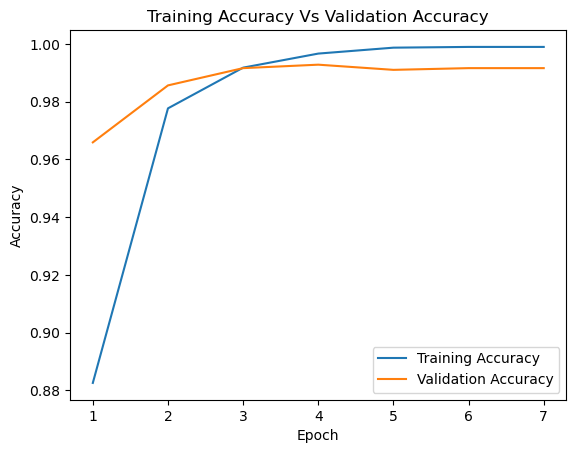

In [22]:
fig = plt.figure()

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Train Accuracy'],label='Training Accuracy')
plt.plot(acc_loss_df['Epoch'],acc_loss_df['Validation Accuracy'],label = 'Validation Accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


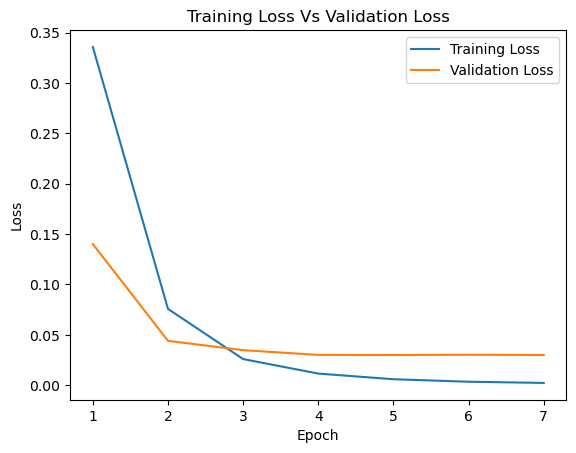

In [23]:
fig = plt.figure()

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Training Loss'],label='Training Loss')

plt.plot(acc_loss_df['Epoch'],acc_loss_df['Validation Loss'],label= 'Validation Loss')

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
threshold = 0.5
result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype("int32")

53/53 - 0s - 8ms/step


In [25]:
from sklearn.metrics import classification_report
target_names = ['spam','ham']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

        spam       0.99      1.00      1.00      1448
         ham       0.99      0.95      0.97       224

    accuracy                           0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672



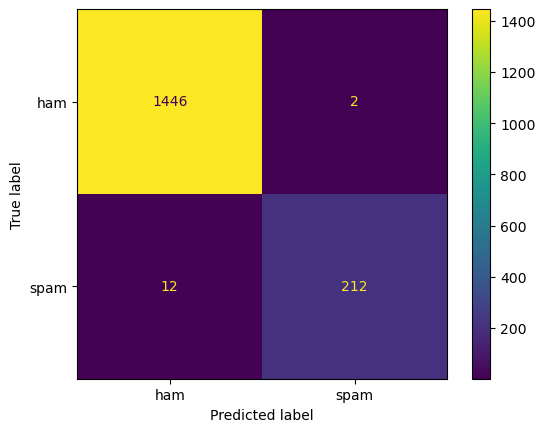

In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(Y_test,result)
classes = ['ham','spam']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

In [27]:
testText="I‘m going to try for 2 months ha ha only joking"
predict_msg = ["	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"]
def predict_spam(predict_msg, threshold=0.5):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen=MAX_LEN)
    predictions = model.predict(padded)
    for pred in predictions:
        if pred > threshold:
            print("Spam")
        else:
            print("Ham")

# Example usage
predict_msg = ["Your free trail is going to end, renew it"]
predict_spam(predict_msg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ham


--------we can do this again with simple Bernoulli Naive Bayes-----------

In [28]:
x=data['Message']
y=data['Category']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [30]:
cv=CountVectorizer()
x=cv.fit_transform(x)

In [31]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42)

In [32]:
model=BernoulliNB()
model.fit(xtrain,ytrain)

BernoulliNB()

In [33]:
ypred=model.predict(xtest)

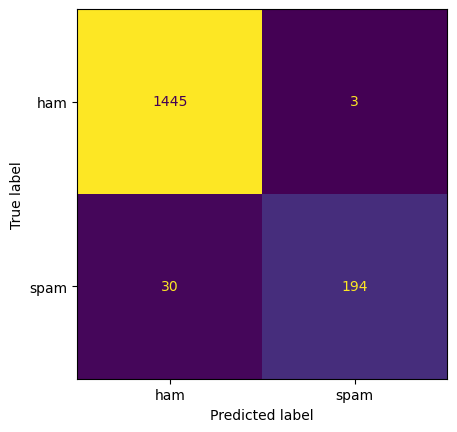

In [34]:
cm=confusion_matrix(ytest,ypred)
classes = ['ham','spam']
ConfusionMatrixDisplay(cm,display_labels=classes).plot(colorbar=False)

-------below using decision tree-------------------

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
treeModel=DecisionTreeClassifier()
treeModel.fit(xtrain,ytrain)
ypred=treeModel.predict(xtest)

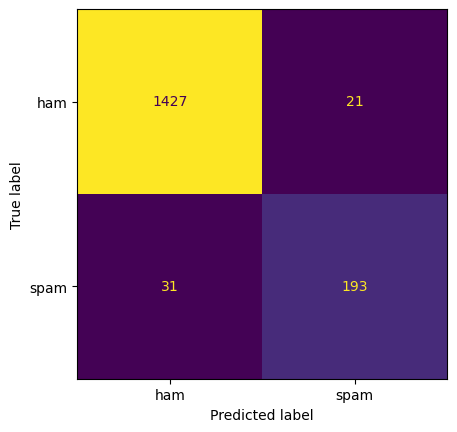

In [37]:
cm=confusion_matrix(ytest,ypred)
classes = ['ham','spam']
ConfusionMatrixDisplay(cm,display_labels=classes).plot(colorbar=False)

-------------------below use random forest--------------------------------

In [38]:
from sklearn.ensemble import RandomForestClassifier

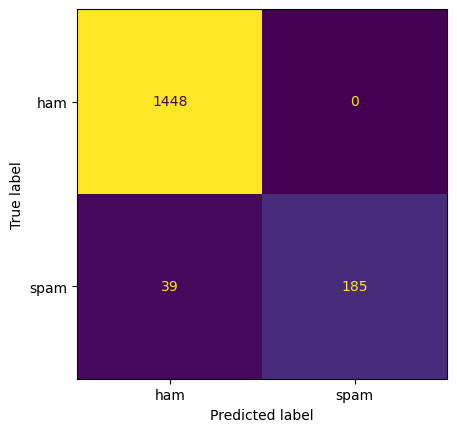

In [39]:
forestModel=RandomForestClassifier()
forestModel.fit(xtrain,ytrain)
ypred=forestModel.predict(xtest)
cm=confusion_matrix(ytest,ypred)
classes = ['ham','spam']
ConfusionMatrixDisplay(cm,display_labels=classes).plot(colorbar=False)

------------------------below use XGBoost---------------------------------------------

In [40]:
from xgboost import XGBClassifier

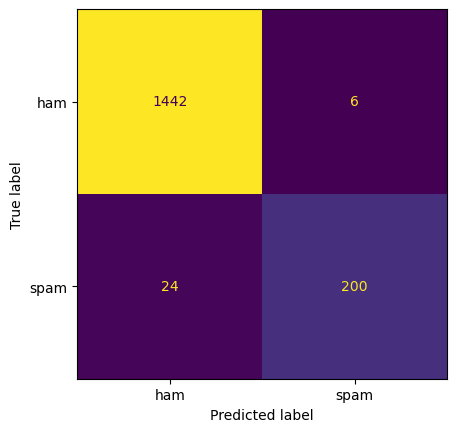

In [41]:
xgbModel=XGBClassifier()
xgbModel.fit(xtrain,ytrain)
ypred=xgbModel.predict(xtest)
cm=confusion_matrix(ytest,ypred)
classes = ['ham','spam']
cmd=ConfusionMatrixDisplay(cm,display_labels=classes)
cmd.plot(colorbar=False)